In [67]:
import tensorflow as tf
from tensorflow import keras as kr
from keras import layers
import pandas as pd
import numpy as np
import os
from env_paths import *
import matplotlib.pyplot as plt
from global_variables import *

In [68]:
def denormalize(predictions):
    for col in INPUT_COLS:
        min, max = MIN_MAX_COLS_VALUES[col]
        predictions[col] = predictions[col] * (max - min) + min

    return predictions

def normalize(df):
    # Normalizacion de cada columna empleando (xi – minimo(x)) / (máximo(x) – minimo(x))
    for col, (min, max) in MIN_MAX_COLS_VALUES.items():
        df[col]=(df[col]-min)/(max-min)

In [69]:
files = os.listdir(CLASSIFIED_SENSOR_PATH)
df = pd.read_csv(CLASSIFIED_SENSOR_PATH + files[0])
df['ts'] = pd.to_datetime(df['ts'], unit="ns")

normalize(df)
df.shape

(350, 7)

In [70]:
learning_rate = 0.01 # Ratio de aprendizaje
batch_size = 8 # Tamanno del conjunto de datos que se introducen en bloque en entrenamiento
epochs = 100 # Epocas de entrenamiento de la RNA
window_size = 5 # Tamanno de la ventana de datos previos para predecir el inmediatamente posterior
train_frac = 0.75 # Fraccion de datos de entrenamiento
val_frac = 0.15 # Fraccion de datos de validacion, el porcentaje restante se dedica a test

In [71]:
rolling_win = df.groupby(pd.Grouper(freq="24H", key="ts"))
data_windows = [] # Ventana de datos para evitar los saltos temporales
data_window = []

# Separamos cada ventana de datos para poder crear el conjunto de datos de entrenamiento
for _, group in rolling_win: 
    if len(group) == 0 and len(data_window) > 0:
        data_windows.append(data_window)
        data_window = []
    if len(group) > 0:
        data_window.append(group[INPUT_COLS].to_numpy()[0])
data_windows.append(data_window)

X = []
y = []
for data_window in data_windows:
    # En cada ventana de datos comprobamos si hay datos suficientes para la prediccion 
    # temporal, sino continuamos con la siguiente ventana
    if(len(data_window) < window_size + 1):
        continue
    # Por cada ventana la recorremos creando una subventana deslizante obteniendo 
    # los inputs de la RNA y el target correspondiente.
    for i in range(len(data_window) - window_size):
        X.append([a for a in data_window[i : i + window_size]])
        y.append(data_window[i + window_size])

X = np.array(X)
y = np.array(y)

# Dividimos el conjunto de datos en entrenamiento, validacion y test.
train_lim = int(len(X) * train_frac)
val_lim = train_lim + int(len(X) * val_frac)

X_train, y_train = X[:train_lim], y[:train_lim]
X_val, y_val = X[train_lim : val_lim], y[train_lim : val_lim]
X_test, y_test = X[val_lim:], y[val_lim:]


In [72]:
model = kr.Sequential()
model.add(layers.InputLayer(X_train.shape[1:]))
model.add(layers.GRU(64))
model.add(layers.Dense(6))

es_callback = kr.callbacks.EarlyStopping(monitor="val_loss", min_delta=0.001, patience=10)
model.compile(loss="mse", optimizer=kr.optimizers.Adam(learning_rate=learning_rate))
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_11 (GRU)                (None, 64)                13824     
                                                                 
 dense_5 (Dense)             (None, 6)                 390       
                                                                 
Total params: 14,214
Trainable params: 14,214
Non-trainable params: 0
_________________________________________________________________


In [73]:
# Entrenamiento de la RNA
history = model.fit(x=X_train, y=y_train, epochs=epochs, batch_size=batch_size, verbose='auto', validation_data=(X_val, y_val), workers=10)

Epoch 1/100
31/31 [==============================] - 5s 26ms/step - loss: 0.0250 - val_loss: 0.0037
Epoch 2/100
31/31 [==============================] - 0s 6ms/step - loss: 0.0010 - val_loss: 8.9419e-04
Epoch 3/100
31/31 [==============================] - 0s 9ms/step - loss: 6.0816e-04 - val_loss: 0.0014
Epoch 4/100
31/31 [==============================] - 0s 7ms/step - loss: 4.4596e-04 - val_loss: 7.2356e-04
Epoch 5/100
31/31 [==============================] - 0s 8ms/step - loss: 3.8552e-04 - val_loss: 0.0010
Epoch 6/100
31/31 [==============================] - 0s 7ms/step - loss: 2.6391e-04 - val_loss: 5.8722e-04
Epoch 7/100
31/31 [==============================] - 0s 7ms/step - loss: 2.6446e-04 - val_loss: 3.5897e-04
Epoch 8/100
31/31 [==============================] - 0s 6ms/step - loss: 2.2263e-04 - val_loss: 3.6931e-04
Epoch 9/100
31/31 [==============================] - 0s 8ms/step - loss: 1.9228e-04 - val_loss: 3.9970e-04
Epoch 10/100
31/31 [==============================] - 0s

In [74]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

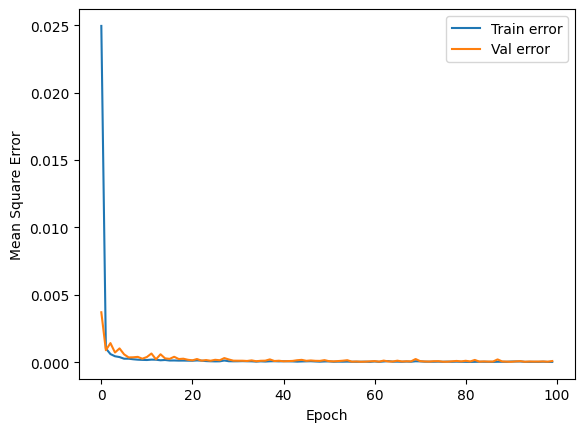

In [75]:
plt.figure()
plt.plot(hist['epoch'], hist['loss'], label='Train error')
plt.plot(hist['epoch'], hist['val_loss'], label='Val error')
plt.xlabel("Epoch")
plt.ylabel("Mean Square Error")
plt.legend()

plt.legend()

In [76]:
targets = pd.DataFrame(data=y_test, columns=INPUT_COLS)
predictions = pd.DataFrame(data=model.predict(X_test), columns=INPUT_COLS)

targets = denormalize(targets)
predictions = denormalize(predictions)

2/2 [==============================] - 0s 3ms/step


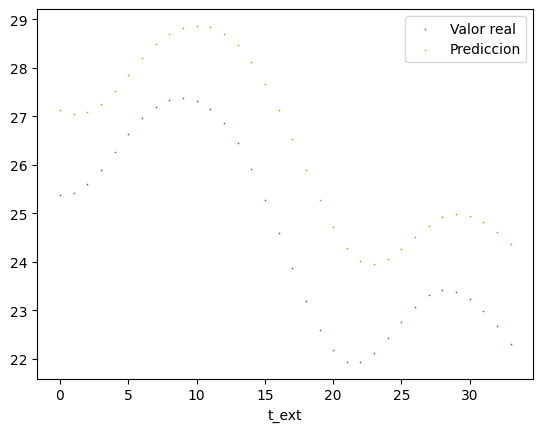

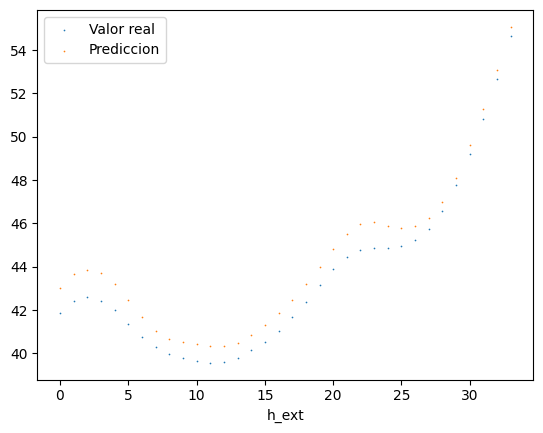

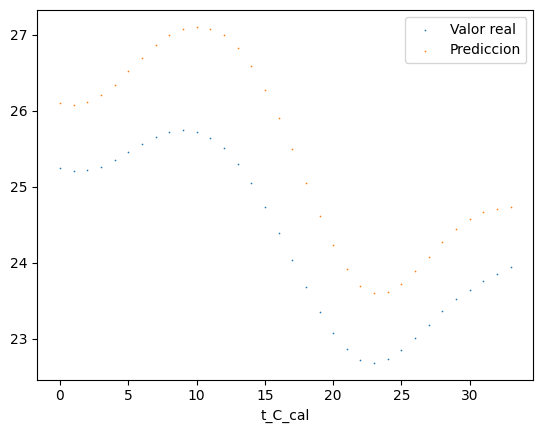

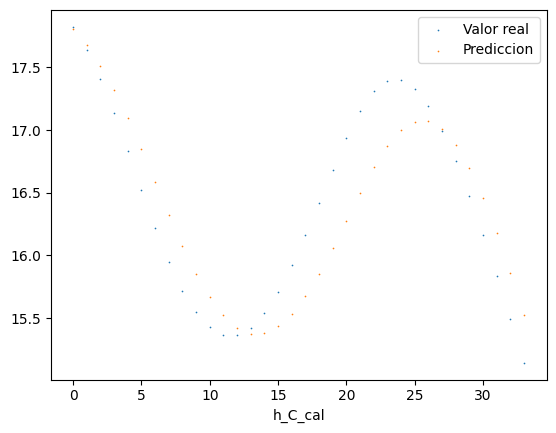

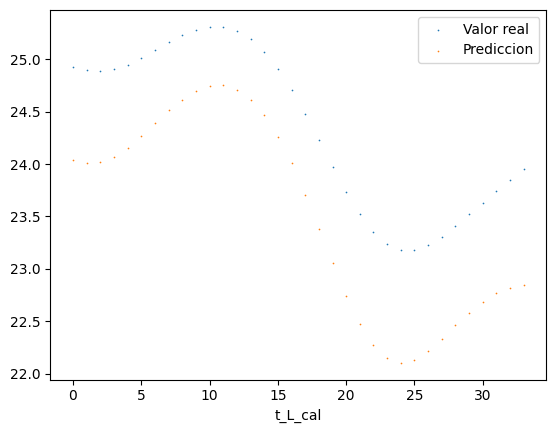

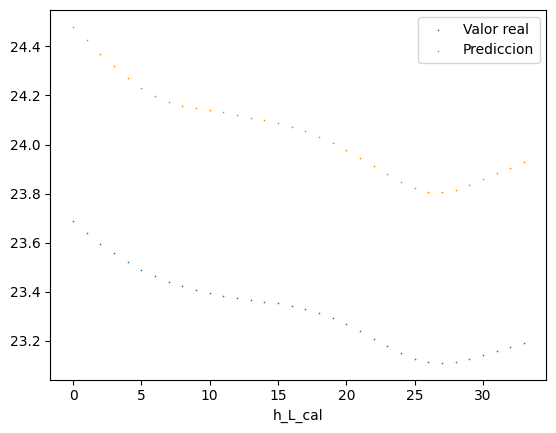

In [77]:
for col in INPUT_COLS:
    plt.figure()
    plt.scatter(range(len(targets[col])), targets[col], linewidths=0.5, s=0.5)
    plt.scatter(range(len(predictions[col])), predictions[col], linewidths=0.5, s=0.5)
    plt.legend(["Valor real", "Prediccion"])
    plt.xlabel(col)
    plt.show()

In [78]:
# model.save("./ann_model", overwrite=True)